In [1]:
modelName = 'dpn92'
filterName = 'None'

point = 'Point1'

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from torchvision import models
from torchvision import transforms
from torchvision.io import read_image

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

from tqdm import tqdm

import random
import os

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):

        self.df = df
        
        self.device = device
        
        self.transform = transform

    def __len__(self):
        return len(self.df)


    def __getitem__(self, idx):
        if idx >= len(self): raise StopIteration

        img = read_image(self.df.loc[idx, 'img_path'])[:3,:,:]
        filename = self.df.loc[idx, 'filename']
        sign = self.df.loc[idx, 'sign']
        
        if self.transform:
            img = self.transform(img)

        return img, filename, sign
    
    def getData(self):
        return list(self)

In [7]:
def createDataFrame():
    
    train_df = pd.read_csv('../../data/train.csv')
    train_df['img_path'] = '../../data/avia-train/avia-train/' + train_df['filename'] + '.png'
    
    test_df = pd.read_csv('../../data/test.csv')
    test_df['img_path'] = '../../data/avia-test/avia-test/' + test_df['filename'] + '.png'
    test_df['sign'] = -1
    
    test_e_df = pd.read_csv('../../data/test_extended.csv', index_col='filename')
    
    test_e_df = test_e_df.drop(test_df['filename'])
    test_e_df['filename'] = test_e_df.index
    
    test_e_df['img_path'] = '../../data/avia-test-extended/avia-test-extended/' + test_e_df['filename'] + '.jpeg'
    test_e_df['sign'] = -1
    
    df = pd.concat((train_df, test_df, test_e_df)).reset_index(drop=True)
    
    df['sign'] = df['sign'].astype('float64')
    
    return df

In [8]:
def createDataLoader(df, batch_size=None, shuffle=False, transform=None):

    batch_size = batch_size if batch_size else len(df)
    
    dataset = CustomImageDataset(df, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    
    return dataset, dataloader

In [9]:
df = createDataFrame()

In [10]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn92', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

Using cache found in C:\Users\Sergey/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


In [11]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=400, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=50, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device).float().reshape(-1, 1)
            
            y_predict = model(X)

            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch+1} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 1 / 15 | Train loss: 0.027513826532023295 | Val loss: 0.009294976320117712
Epoch: 2 / 15 | Train loss: 0.007626078997014297 | Val loss: 0.005663121263612993
Epoch: 3 / 15 | Train loss: 0.0055381608785070955 | Val loss: 0.006209363579866477
Epoch: 4 / 15 | Train loss: 0.00438942037345398 | Val loss: 0.005225066752056591
Epoch: 5 / 15 | Train loss: 0.0034895793309376115 | Val loss: 0.005031404621549882
Epoch: 6 / 15 | Train loss: 0.0036978616729371307 | Val loss: 0.005268037160800304
Epoch: 7 / 15 | Train loss: 0.002284161689911141 | Val loss: 0.005549432473897468
Epoch: 8 / 15 | Train loss: 0.002223486524945613 | Val loss: 0.004627108746411977
Epoch: 9 / 15 | Train loss: 0.002111612696483332 | Val loss: 0.004438145480671665
Epoch: 10 / 15 | Train loss: 0.0028202183115469764 | Val loss: 0.0037553547212737614
Epoch: 11 / 15 | Train loss: 0.0012524823784284915 | Val loss: 0.004201044309302233
Epoch: 12 / 15 | Train loss: 0.0015472034313475773 | Val loss: 0.0048945781814982185
Epoch:

14


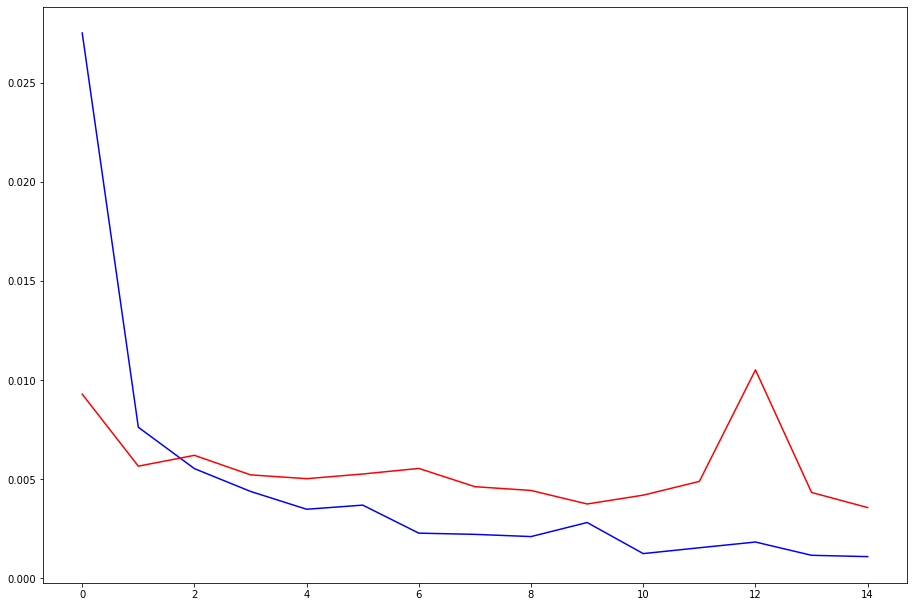

In [12]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [13]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn92', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

Using cache found in C:\Users\Sergey/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


<All keys matched successfully>

In [14]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=50, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 16min 57s


In [15]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [16]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename  model filter   point  v  \
0       66dd512c-30f4-4a6d-bc60-76d4eb54e256  dpn92   None  Point1  0   
1       37048008-aca4-4a64-a9f4-a2ce0d74dd57  dpn92   None  Point1  0   
2       b5ee54d4-a2cc-4859-8eb9-1d040fd88809  dpn92   None  Point1  0   
3       22259884-995b-4c9c-bb24-207decc2a292  dpn92   None  Point1  0   
4       1ee4f60c-e833-4e7c-9d8b-eefb22bf4c91  dpn92   None  Point1  0   
...                                      ...    ...    ...     ... ..   
528315  e189a791-a0ba-4fd1-a3cd-8163bee89527  dpn92   None  Point1  3   
528316  5ea7255d-f168-45a4-9b16-7433fcd05c48  dpn92   None  Point1  3   
528317  20ded678-f040-4313-91df-b5e265b059da  dpn92   None  Point1  3   
528318  5aea9d52-479c-4493-8b4e-0dd905988354  dpn92   None  Point1  3   
528319  4278f122-6a81-4b76-8ff8-15b20b26b171  dpn92   None  Point1  3   

         predict  sign  
0       0.000127  -1.0  
1       0.000132  -1.0  
2       0.000168  -1.0  
3       0.000126  -1.0  
4       0.000181   0.0  
...          ...   ...  
528315  0.000157   0.0  
528316  0.000105  -1.0  
528317  0.000109  -1.0  
528318  0.000116  -1.0  
528319  0.000102  -1.0  

[528320 rows x 7 columns]

In [17]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)

In [18]:
modelName = 'dpn92'
filterName = 'None'
point = 'Point2'

pointLoad = 'Point1'

In [19]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn92', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{pointLoad}.pt'))


weight = torch.tensor([sum(df['sign'] == 1) / sum(df['sign'] != -1)])
criterion = nn.BCELoss(weight=weight, reduction='mean')
criterion.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.000001)

Using cache found in C:\Users\Sergey/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


In [20]:
%%time

def f():
    log = {'loss': {'train': [], 'val': []}, 'bestEpoch':0}
    
    epochs = 15
    
    train_df, val_df = train_test_split(df[df['sign'] != -1], test_size=0.2, random_state=42)
    train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)
    
    traintransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),

        transforms.ToTensor(),
    ])
    _, train_dataloader = createDataLoader(train_df, batch_size=400, shuffle=True, transform=traintransform)
    
    valTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, val_dataloader = createDataLoader(val_df, batch_size=50, shuffle=True, transform=valTransform)
    
    
    model.to(device)
    
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for X, _, y in train_dataloader:
            optimizer.zero_grad()

            X, y = X.to(device), y.to(device).float().reshape(-1, 1)

            y_predict = model(X)
            
            loss = criterion(y_predict, y)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
        log['loss']['train'].append(running_loss/len(train_dataloader))
        
        # Val
        model.eval()
        running_loss = 0
        for X, _, y in val_dataloader:

            X, y = X.to(device), y.to(device).float()

            y_predicted1 = model(X)
            y_predicted2 = model(transforms.RandomHorizontalFlip(p=1)(X))
            y_predicted3 = model(transforms.RandomVerticalFlip(p=1)(X))
            y_predicted4 = model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X)))

            y_predict = torch.cat((y_predicted1, y_predicted2, y_predicted3, y_predicted4), dim=1).mean(dim=1)

            loss = criterion(y_predict, y)
            running_loss += loss.item()


        log['loss']['val'].append(running_loss/len(val_dataloader))

        if not log['bestEpoch'] or log['loss']['val'][-1] < min(log['loss']['val'][:-1]):
            torch.save(model.state_dict(), f'./models/{modelName}_{filterName}_{point}.pt')
            log['bestEpoch'] = epoch

        print(f"Epoch: {epoch} / {epochs} | Train loss: {log['loss']['train'][-1]} | Val loss: {log['loss']['val'][-1]}")
            
    return log
        
log = f()    

Epoch: 0 / 15 | Train loss: 0.0006144872785957959 | Val loss: 0.0034255113678082127
Epoch: 1 / 15 | Train loss: 0.00039311622631863603 | Val loss: 0.0033453332019562367
Epoch: 2 / 15 | Train loss: 0.00035618025740693577 | Val loss: 0.003381570653684321
Epoch: 3 / 15 | Train loss: 0.0004254571851185848 | Val loss: 0.003368759031087393
Epoch: 4 / 15 | Train loss: 0.0003244099845312395 | Val loss: 0.0032750942044513067
Epoch: 5 / 15 | Train loss: 0.0003227469720542782 | Val loss: 0.0032281001320516225
Epoch: 6 / 15 | Train loss: 0.000226808387182361 | Val loss: 0.0033372025575808947
Epoch: 7 / 15 | Train loss: 0.0002094355022563832 | Val loss: 0.0032741657485967153
Epoch: 8 / 15 | Train loss: 0.00023854660685174167 | Val loss: 0.0033550015862565488
Epoch: 9 / 15 | Train loss: 0.00019984602985214368 | Val loss: 0.003396563352041994
Epoch: 10 / 15 | Train loss: 0.00016838402757818428 | Val loss: 0.0032905945333332057
Epoch: 11 / 15 | Train loss: 0.00014423296915848613 | Val loss: 0.00344655

5


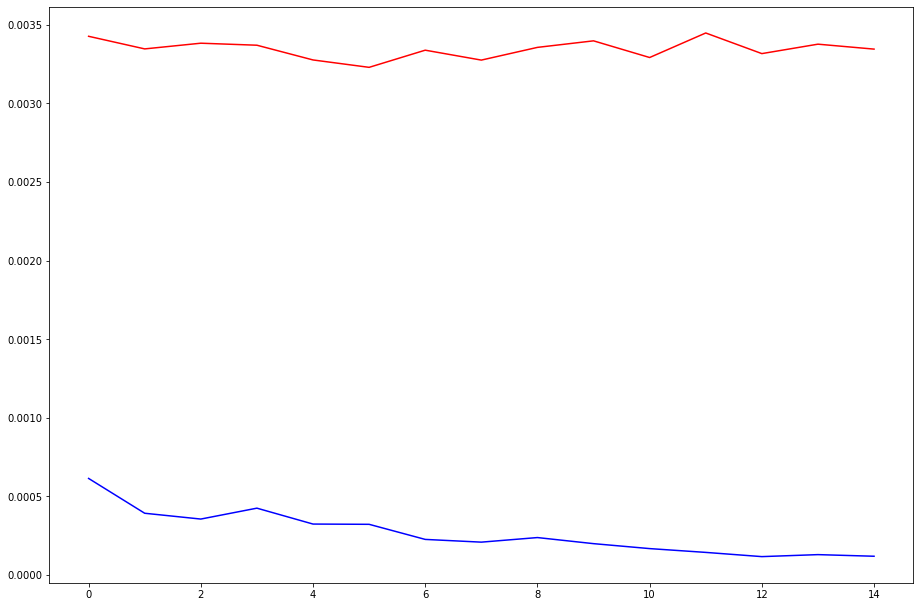

In [21]:
print(log['bestEpoch'])

fig = plt.figure()
axes = fig.add_axes([1, 1, 2, 2])

axes.plot(range(len(log['loss']['train'])), log['loss']['train'], 'b')
axes.plot(range(len(log['loss']['val'])), log['loss']['val'], 'r')
plt.show()

In [22]:
model = torch.hub.load('rwightman/pytorch-dpn-pretrained', 'dpn92', pretrained=True)
    
model.classifier = torch.nn.Sequential(
    nn.Conv2d(model.classifier.in_channels, 1, kernel_size=(1, 1), stride=(1, 1)),
    nn.Sigmoid()
)

model.load_state_dict(torch.load(f'./models/{modelName}_{filterName}_{point}.pt'))

Using cache found in C:\Users\Sergey/.cache\torch\hub\rwightman_pytorch-dpn-pretrained_master


<All keys matched successfully>

In [23]:
%%time
with torch.no_grad():
    model.eval()
    model.to(device)

    test_df = df.copy()
    test_df = test_df.reset_index(drop=True)
    
    testTransform = transforms.Compose([
        transforms.Resize(33),
        transforms.ToPILImage(),

        transforms.ToTensor(),
    ])
    _, test_dataloader = createDataLoader(test_df, batch_size=50, shuffle=True, transform=testTransform)
    
    filenames = []
    sign = []
    predicteds = [[], [], [], []]
    
    for X, filename, y in test_dataloader:

        X = X.to(device)
        
        predicteds[0].append(model(X).reshape(-1).cpu())
        predicteds[1].append(model(transforms.RandomHorizontalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[2].append(model(transforms.RandomVerticalFlip(p=1)(X)).reshape(-1).cpu())
        predicteds[3].append(model(transforms.RandomVerticalFlip(p=1)(transforms.RandomHorizontalFlip(p=1)(X))).reshape(-1).cpu())
        
        sign.append(y)
        filenames += filename
        
predicteds[0] = torch.cat(predicteds[0], 0)
predicteds[1] = torch.cat(predicteds[1], 0)
predicteds[2] = torch.cat(predicteds[2], 0)
predicteds[3] = torch.cat(predicteds[3], 0)

sign = torch.cat(sign)

Wall time: 9min 5s


In [24]:
predict_df1 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 0,
    
    'predict': predicteds[0],
    'sign': sign,
})

predict_df2 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 1,
    
    'predict': predicteds[1],
    'sign': sign,
})

predict_df3 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 2,
    
    'predict': predicteds[2],
    'sign': sign,
})

predict_df4 = pd.DataFrame({
    'filename': filenames,
    'model': modelName,
    'filter': filterName,
    'point': point,
    'v': 3,
    
    'predict': predicteds[3],
    'sign': sign,
})

In [25]:
predict_df = pd.concat((predict_df1, predict_df2, predict_df3, predict_df4)).reset_index(drop=True)
predict_df

filename  model filter   point  v  \
0       66dd512c-30f4-4a6d-bc60-76d4eb54e256  dpn92   None  Point2  0   
1       37048008-aca4-4a64-a9f4-a2ce0d74dd57  dpn92   None  Point2  0   
2       b5ee54d4-a2cc-4859-8eb9-1d040fd88809  dpn92   None  Point2  0   
3       22259884-995b-4c9c-bb24-207decc2a292  dpn92   None  Point2  0   
4       1ee4f60c-e833-4e7c-9d8b-eefb22bf4c91  dpn92   None  Point2  0   
...                                      ...    ...    ...     ... ..   
528315  e189a791-a0ba-4fd1-a3cd-8163bee89527  dpn92   None  Point2  3   
528316  5ea7255d-f168-45a4-9b16-7433fcd05c48  dpn92   None  Point2  3   
528317  20ded678-f040-4313-91df-b5e265b059da  dpn92   None  Point2  3   
528318  5aea9d52-479c-4493-8b4e-0dd905988354  dpn92   None  Point2  3   
528319  4278f122-6a81-4b76-8ff8-15b20b26b171  dpn92   None  Point2  3   

         predict  sign  
0       0.000065  -1.0  
1       0.000065  -1.0  
2       0.000079  -1.0  
3       0.000063  -1.0  
4       0.000090   0.0  
...          ...   ...  
528315  0.000072   0.0  
528316  0.000053  -1.0  
528317  0.000057  -1.0  
528318  0.000059  -1.0  
528319  0.000054  -1.0  

[528320 rows x 7 columns]

In [26]:
predict_df.to_csv(f'predicteds/{modelName}_{filterName}_{point}.csv', index=False)